In [1]:
import sys
sys.path.append("..") 

2025-07-30 23:15:52,882 | INFO | Loaded Brent data: 8360 rows.
2025-07-30 23:15:52,890 | INFO | Loaded event data: 14 rows.


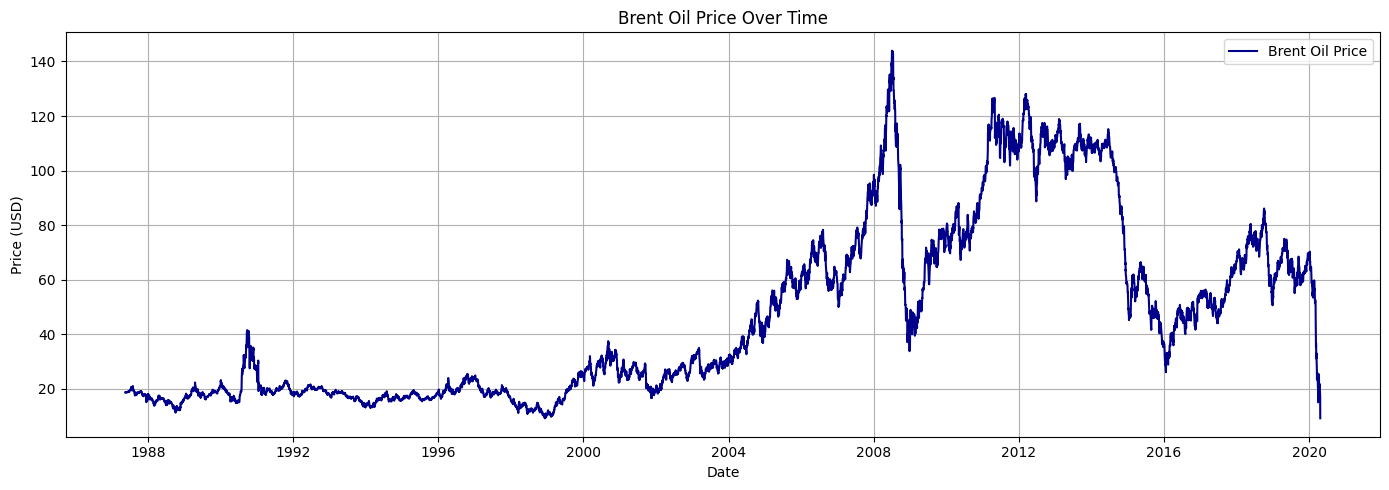

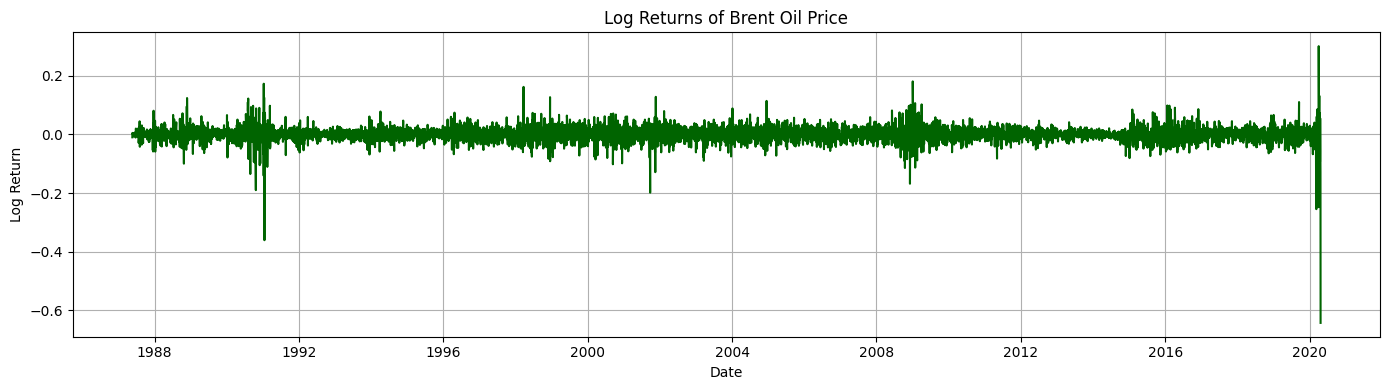

{'ADF Statistic': np.float64(-12.603088598261737),
 'p-value': np.float64(1.719110914309061e-23),
 'Used Lag': 29,
 'Number of Observations': 8329,
 'Critical Values': {'1%': np.float64(-3.431135366372075),
  '5%': np.float64(-2.8618870775509087),
  '10%': np.float64(-2.5669547445378043)},
 'Conclusion': 'Stationary'}

In [2]:
from modules.config import PRICE_FILE, EVENT_FILE
from modules.data_loader import load_brent_data
from modules.event_collector import load_event_data
from modules.eda import plot_price_trend, plot_log_returns
from modules.time_series_utils import compute_log_returns, check_stationarity

df = load_brent_data(PRICE_FILE)
df_events = load_event_data(EVENT_FILE)

plot_price_trend(df)
plot_log_returns(df)

log_df = compute_log_returns(df)
result = check_stationarity(log_df["Log_Return"])
result


In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
import pandas as pd
import pandas as pd
import pymc as pm
import numpy as np

from modules.config import PRICE_FILE, EVENT_FILE
from modules.data_loader import load_brent_data
from modules.event_collector import load_event_data
from modules import preprocessing, change_point_model, visualization, insight_generation


In [4]:

brent_df = load_brent_data(PRICE_FILE)
events_df = load_event_data(EVENT_FILE)

2025-07-31 14:41:42,458 | INFO | Loaded Brent data: 8360 rows.
2025-07-31 14:41:42,461 | INFO | Loaded event data: 14 rows.


In [5]:
# Make sure Date columns are datetime
brent_df["Date"] = pd.to_datetime(brent_df["Date"])
events_df["Start_Date"] = pd.to_datetime(events_df["Start_Date"])


In [6]:
# 3. Sort by date
brent_df = brent_df.sort_values("Date").reset_index(drop=True)


In [7]:
# 4. Compute log returns
brent_df = preprocessing.compute_log_returns(brent_df, price_col="Price")


In [8]:
# 5. Extract log returns numpy array
log_returns = brent_df["Log_Return"].values


In [9]:
# 6. Build and sample the Bayesian change point model
model = change_point_model.build_change_point_model(log_returns)
trace = change_point_model.sample_model(model, draws=3000, tune=1500, target_accept=0.95)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma_1, sigma_2]


Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 7 seconds.


In [10]:
# use pip install "numpy<2.0.0" "scipy<=1.12.0"
# pip install --force-reinstall aesara==2.9.4

| Library    | Purpose                            | Typical Use in ML/Stats                            |
| ---------- | ---------------------------------- | -------------------------------------------------- |
| **Aesara** | Symbolic math & computation graphs | Bayesian modeling (PyMC), gradient-based inference |
| **SciPy**  | Scientific computing tools         | Stats, optimization, numerical methods             |


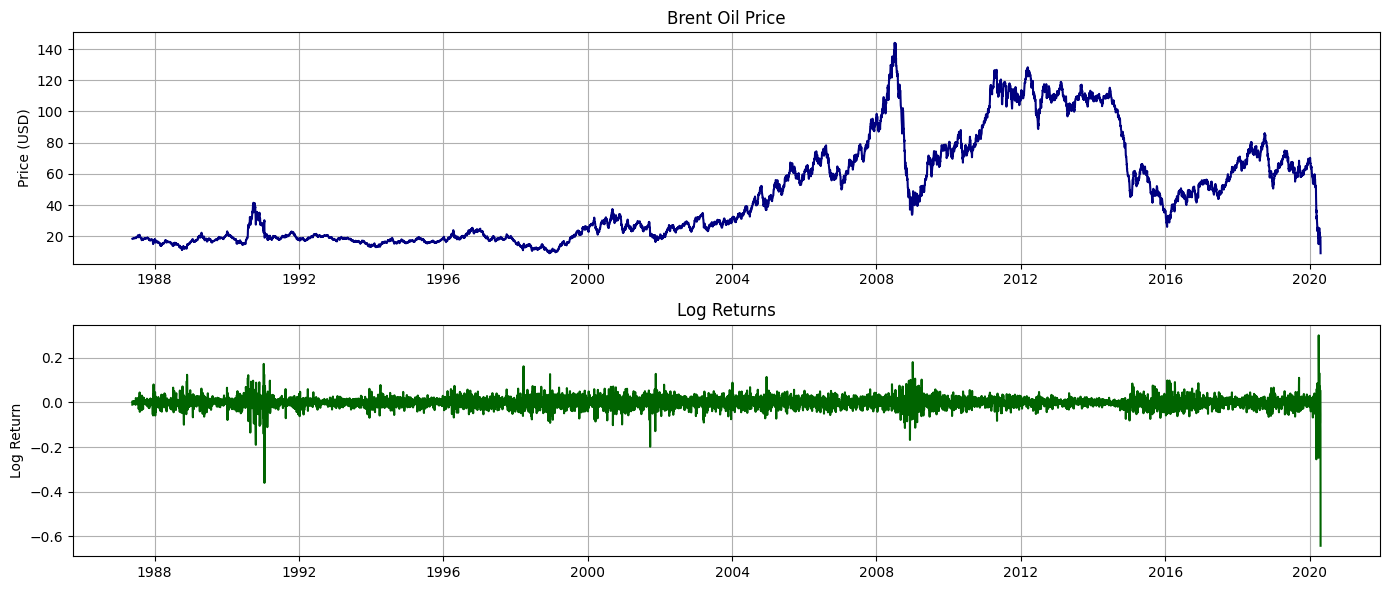

In [10]:
# 7. Plot price and log returns
visualization.plot_price_and_log_returns(brent_df)


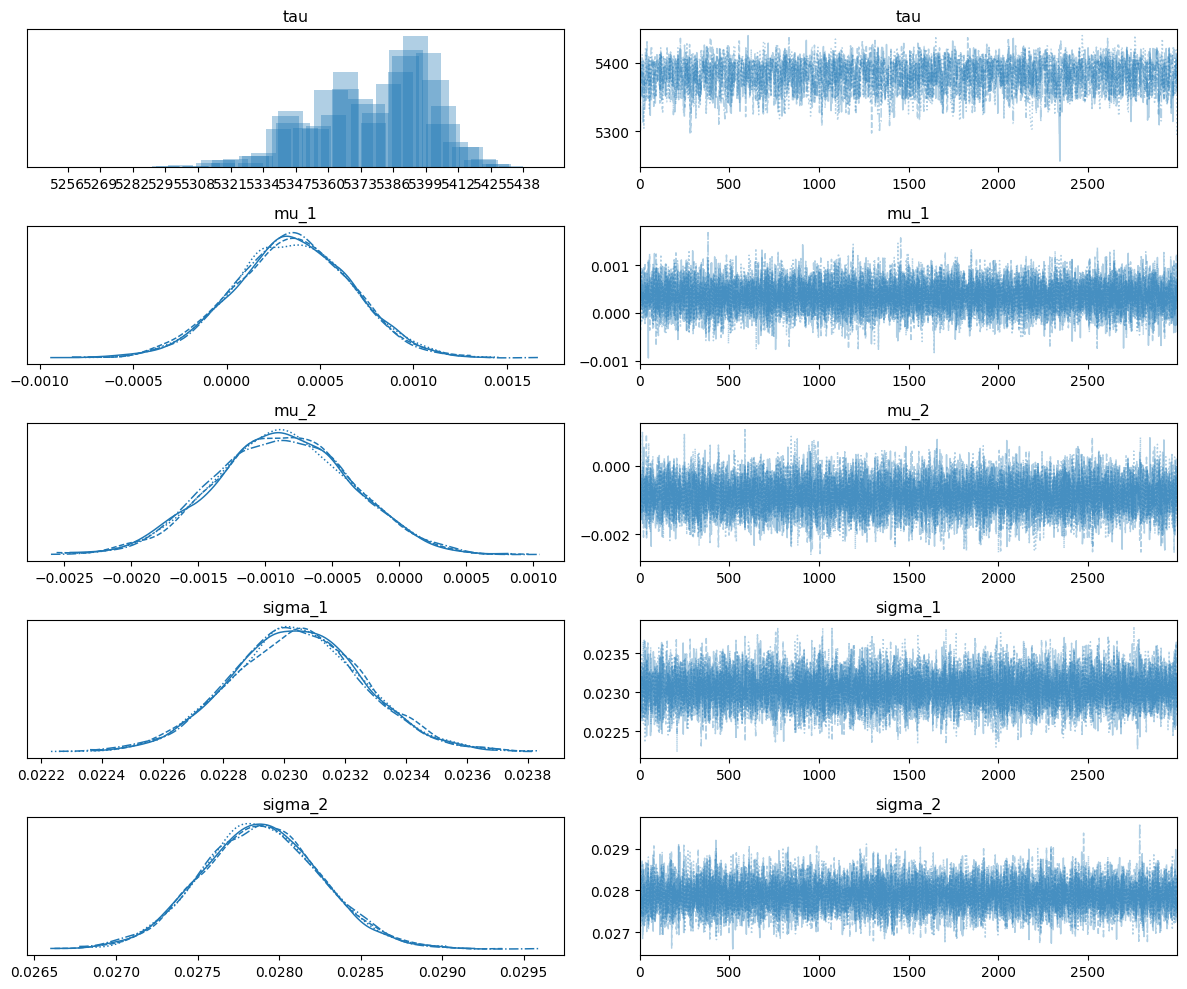

             mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau      5383.205  23.192  5344.000  5422.000      0.516    0.385    2128.0   
mu_1        0.000   0.000    -0.000     0.001      0.000    0.000   14377.0   
mu_2       -0.001   0.001    -0.002     0.000      0.000    0.000   13844.0   
sigma_1     0.023   0.000     0.023     0.023      0.000    0.000   12848.0   
sigma_2     0.028   0.000     0.027     0.029      0.000    0.000   14211.0   

         ess_tail  r_hat  
tau        2282.0    1.0  
mu_1       8647.0    1.0  
mu_2       8436.0    1.0  
sigma_1    8473.0    1.0  
sigma_2    8488.0    1.0  


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,5383.205,23.192,5344.000,5422.000,0.516,0.385,2128.0,2282.0,1.0
mu_1,0.000,0.000,-0.000,0.001,0.000,0.000,14377.0,8647.0,1.0
mu_2,-0.001,0.001,-0.002,0.000,0.000,0.000,13844.0,8436.0,1.0
sigma_1,0.023,0.000,0.023,0.023,0.000,0.000,12848.0,8473.0,1.0
sigma_2,0.028,0.000,0.027,0.029,0.000,0.000,14211.0,8488.0,1.0


In [11]:
# 8. Diagnostics: trace summary
visualization.plot_trace_summary(trace)


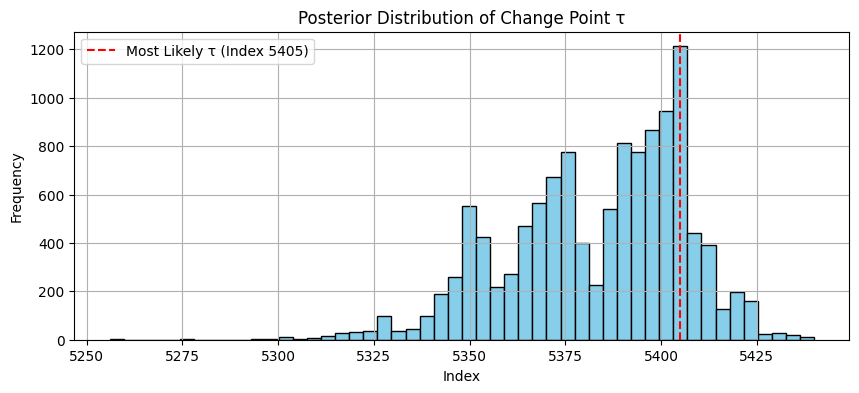

Most likely change point date: 2008-08-20 00:00:00


In [12]:
# 9. Plot change point posterior and get date
change_point_date = visualization.plot_tau_posterior(trace, brent_df["Date"])
print(f"Most likely change point date: {change_point_date}")


In [13]:
# 10. Associate closest event to change point
closest_event = insight_generation.associate_event(change_point_date, events_df)
print("Closest event to change point:")
print(closest_event)

Closest event to change point:
{'Event': 'U.S. Iran Sanctions (Reinstated)', 'Start_Date': Timestamp('2018-11-05 00:00:00'), 'Region': 'Iran/U.S.', 'Type': 'Sanctions', 'Notes': 'Reimposed sanctions limited Iranian oil exports', 'Delta': Timedelta('3729 days 00:00:00')}


In [14]:
# 11. Quantify impact before and after change point
mean_before, mean_after, pct_change = insight_generation.quantify_impact(trace)
print(f"Mean before change: {mean_before:.4f}")
print(f"Mean after change: {mean_after:.4f}")
print(f"Percent change: {pct_change:.2f}%")

Mean before change: 0.0004
Mean after change: -0.0009
Percent change: -347.28%
